**A CNN MODEL FOR IMAGE CLASSIFICATION OF LANDFILL WASTE**

**BACKGROUND**  
Increasing urbanisation, population increase, rising consumption patterns intwined with a 'throw-away' culture have generated higher amounts of waste. This is challenging situation for effective waste management and recycling. Consequently. many inappropriate items end up in landfill sites causing environmental harm through greenhouse gas emissions, affecting water quality and potentially having human health risks. Being able to correctly identify and then sort waste items is a crucial process.

The RealWaste dataset used in this model, was created because of the existing deficits in waste classification and the limitations of many datasets, which often depend on unsullied and virgin materials. Training models on such data results in inaccurate classification when it collides with reality of actual waste. Human visual inspection and manual sorting are too labour intensive, not particularly scalable and can also be prone to error. Convolutional Neural Networks (CNNs) show promise in having a tangible impact in this field.

The RealWaste dataset includes diverse and contaminated samples from a real landfill in Australia in 2023. It has 4752 instances of 9 categories of waste: "Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation".

The objective of this model is to be able to classify images with 70-80% accuracy, which is considered generally good standard. The paper associated with the dataset reached 86% accuracy, but this model is impeded by the inexperience of the author.


**METHODOLOGY - A 'HOW TO' GUIDE**
  

Firstly, setup and import the necessary packages.

In [1]:
# Import what is required
import requests
import zipfile
import os
import shutil
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import numpy as np
import tensorflow as tf
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Find and download the dataset. Double-check it has extracted.

In [2]:
# Get the data

# URL of the RealWaste dataset
url = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"

# Path to save the downloaded file
zip_path = "realwaste.zip"

# Download the dataset
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("realwaste_dataset")

print("Yay! Download and extraction complete!")

Yay! Download and extraction complete!


Reproducibility is good practice for experiments and makes TensorFlow operations deterministic. Configure Matplotlib for better visualisation.

In [ ]:
# Reproducibility
def set_seed(seed=186282):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # in case things get messy

Coduct initial exploration of the data to understand the distribution. There are 9 major material types classfied in 4752 instances, but are they all equally spread?

Category counts: Counter({'Plastic': 921, 'Metal': 790, 'Paper': 500, 'Miscellaneous Trash': 495, 'Cardboard': 461, 'Vegetation': 436, 'Glass': 420, 'Food Organics': 411, 'Textile Trash': 318})


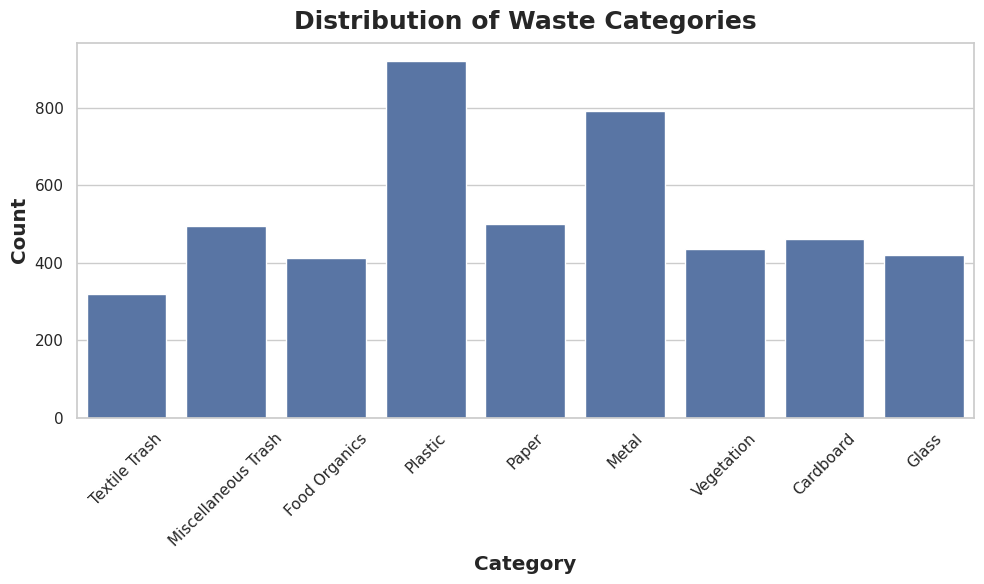

In [4]:
# Define the directory containing the images and check
original_dir = pathlib.Path("realwaste_dataset/realwaste-main/RealWaste")
if not os.path.exists(original_dir):
    print(f"Directory not found: {original_dir}") # hopefully it is there!
else:
    category_folders = [folder for folder in os.listdir(original_dir)
    if os.path.isdir(os.path.join(original_dir, folder))]
    category_counter = Counter()
    for category in category_folders:
        category_path = os.path.join(original_dir, category)
        jpeg_images = [file for file in os.listdir(category_path)
    if file.endswith('.jpg')]
        category_counter[category] = len(jpeg_images)

    print("Category counts:", category_counter) # get a number for each cat

# Visualise the categories
    category_df = pd.DataFrame.from_dict(category_counter, orient='index', columns=['count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_df.index, y=category_df['count'])
    plt.title('Distribution of Waste Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

It looks like plastic and metal are overly represented in comparison to the others and would skew our training.

The next step involves splitting the data up to train the model, validate and then test. Because of the distribution use a stratified technique so each of the categories is fairly represented in each split.

In [5]:
# Define
new_base_dir = pathlib.Path("realwaste_dataset_small")

# Define the categories
categories = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

# Create subsets
def make_subset(subset_name, files):
    for category in categories:
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        if category in files:
            for file_path in files[category]:
                shutil.copy(file_path, dir / file_path.name)

category_files = {category: list((original_dir / category).glob("*.jpg")) for category in categories}

# Split the data into train, validation, and test sets using stratified splitting
train_files = {}
valid_files = {}
test_files = {}

for category in categories:
    if len(category_files[category]) > 0:
        train_and_valid, test = train_test_split(category_files[category], test_size=0.1, random_state=451)
        train, valid = train_test_split(train_and_valid, test_size=0.1 / 0.9, random_state=451) # Let's show Ray Bradbury some respect
        train_files[category] = train
        valid_files[category] = valid
        test_files[category] = test

# Make subsets
make_subset("train", train_files)
make_subset("validation", valid_files)
make_subset("test", test_files)

print("Files have been copied to train, validation, and test directories.") # reassurance!

Files have been copied to train, validation, and test directories.


Double-check they exist and are distributed with no empty directories.

In [6]:
# Verify the new directories
for subset in ["train", "validation", "test"]:
    for category in categories:
        category_path = os.path.join(new_base_dir, subset, category)
        if os.path.exists(category_path):
            print(f"{subset}/{category} directory has {len(os.listdir(category_path))} files.")
        else:
            print(f"{subset}/{category} directory does not exist.")

train/Cardboard directory has 368 files.
train/Food Organics directory has 328 files.
train/Glass directory has 336 files.
train/Metal directory has 632 files.
train/Miscellaneous Trash directory has 395 files.
train/Paper directory has 400 files.
train/Plastic directory has 736 files.
train/Textile Trash directory has 254 files.
train/Vegetation directory has 348 files.
validation/Cardboard directory has 46 files.
validation/Food Organics directory has 41 files.
validation/Glass directory has 42 files.
validation/Metal directory has 79 files.
validation/Miscellaneous Trash directory has 50 files.
validation/Paper directory has 50 files.
validation/Plastic directory has 92 files.
validation/Textile Trash directory has 32 files.
validation/Vegetation directory has 44 files.
test/Cardboard directory has 47 files.
test/Food Organics directory has 42 files.
test/Glass directory has 42 files.
test/Metal directory has 79 files.
test/Miscellaneous Trash directory has 50 files.
test/Paper dire

Good. Now load the datasets.

In [7]:
# Load the data
train_dataset = image_dataset_from_directory(
    'realwaste_dataset_small/train',
    image_size=(256, 256),
    batch_size=32, # batch size
    label_mode='categorical'  # one-hot encoding
)

valid_dataset = image_dataset_from_directory(
    'realwaste_dataset_small/validation',
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    'realwaste_dataset_small/test',
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical'
)

Found 3797 files belonging to 9 classes.
Found 476 files belonging to 9 classes.
Found 479 files belonging to 9 classes.


Get an idea of the images the model will work with.

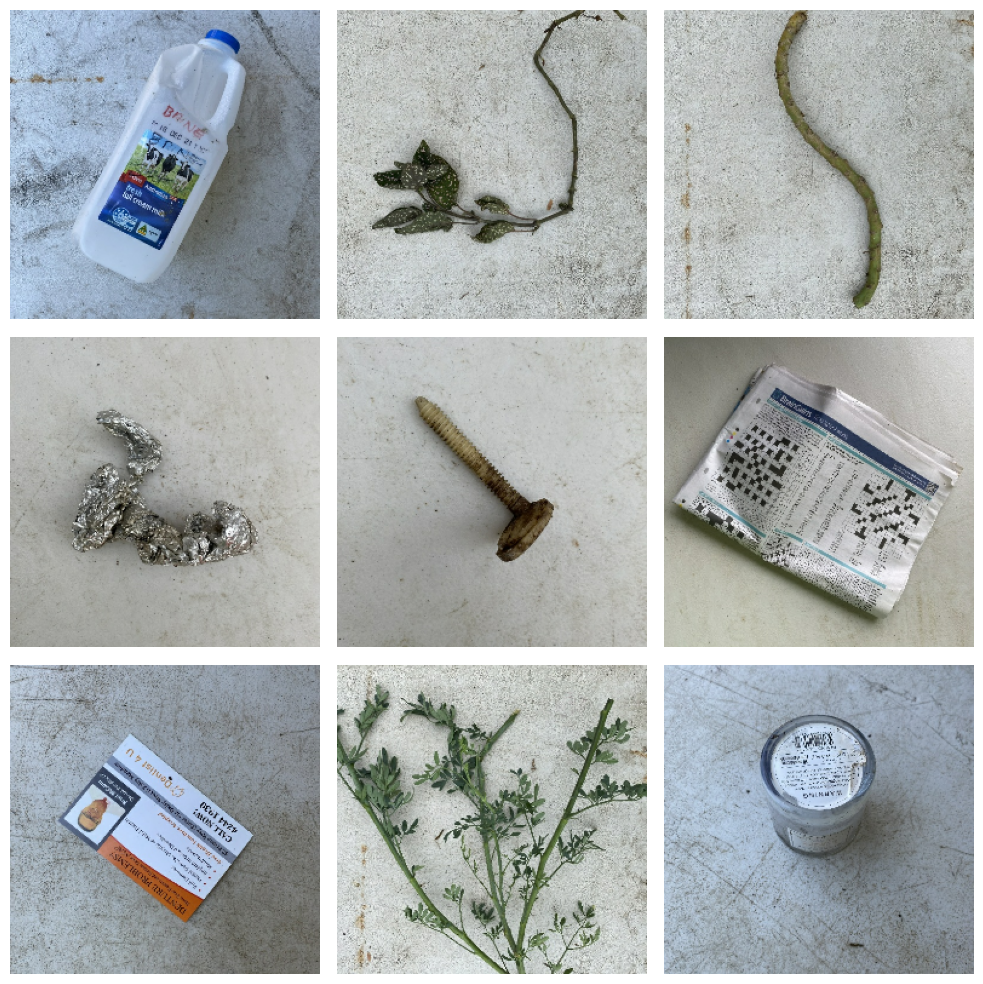

In [8]:
# Display some raw images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

The pixel values now need to be normalised so that the input data is on a similar scale. This process helps stabilise and speed up the training of neural networks, improving the performance and convergence of the model. To the human eye they won't look different.

In [ ]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset_normalized = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset_normalized = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset_normalized = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Display some images after normalisation to check they are there
plt.figure(figsize=(10, 10))
for images, _ in train_dataset_normalized.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

Pre-process the data via augmentation and check the results. Augmentation includes random horizontal and vertical flips, rotations, and zooms - it artificially increases the diversity of the training data, which is important as 4752 instances is a small dataset.

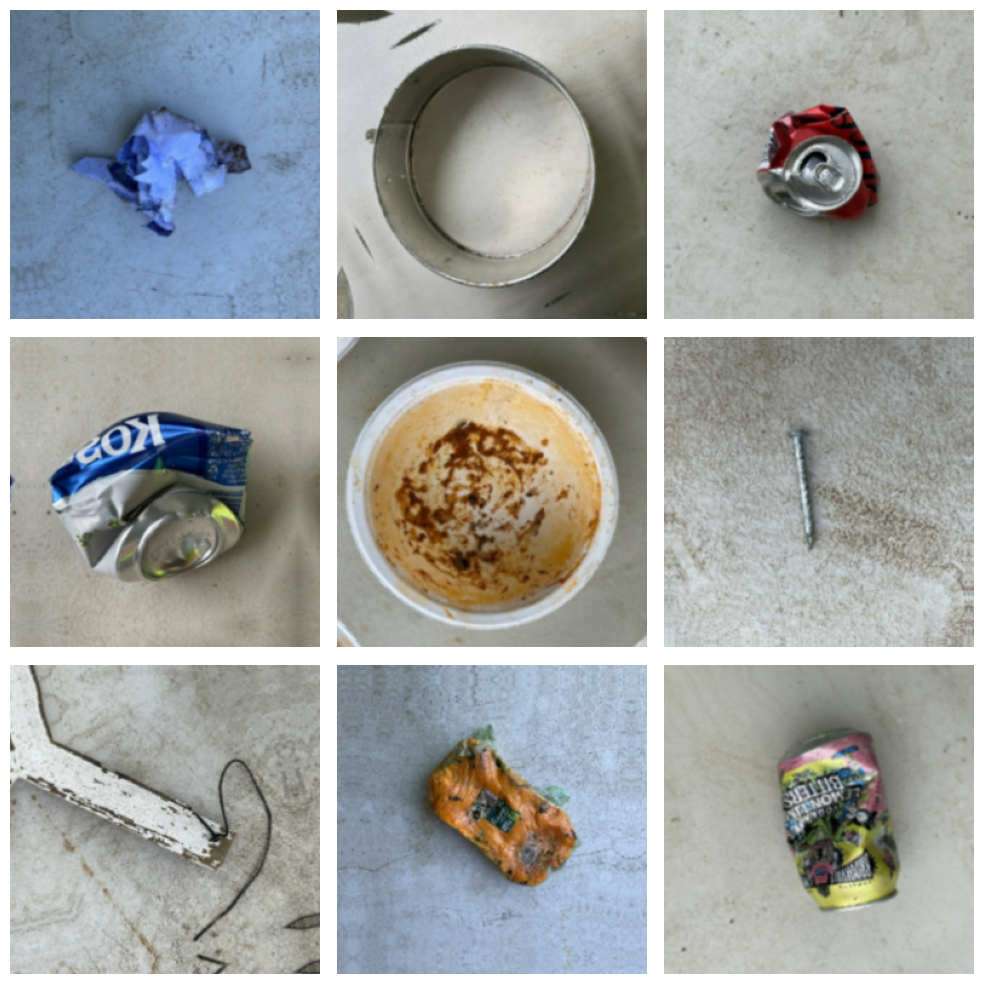

In [10]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Apply augmentation to the normalized training dataset
augmented_train_dataset = train_dataset_normalized.map(lambda x, y: (data_augmentation(x, training=True), y))

# Display some augmented images
plt.figure(figsize=(10, 10))
for images, _ in augmented_train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(tf.squeeze(augmented_image).numpy())
        plt.axis("off")

Nearly all models rely on a base that has a pre-trained model. It is even more important for a small dataset because using a pre-trained model leverages the knowledge already learned from a large dataset, in this case ImageNet, which can significantly improve performance and reduce training time.   

Load the MobileNetV2 model and extract the features. This forms the base to which the classifying head will next be attached.

In [11]:
# Load pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)
base_model.trainable = False

# Create and extract features
feature_extractor = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        resized_images = tf.image.resize(images, [224, 224])
        features.append(feature_extractor(resized_images))
        labels.append(lbls)
    return tf.concat(features, axis=0), tf.concat(labels, axis=0)

train_features, train_labels = extract_features(train_dataset)
valid_features, valid_labels = extract_features(valid_dataset)
test_features, test_labels = extract_features(test_dataset)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Add the customised classification head and compile the model.   
'adam' is efficient and widely used for training deep learning models. The loss function is suitable for multi-class classification problems and accuracy is a common metric. The callbacks help save time and resources.

In [ ]:
# Add a classification head
classifier = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features.shape[1],)), # defines input shape
    tf.keras.layers.Dense(128, activation='relu'),  #add a fully connected layer with activation function
    tf.keras.layers.Dropout(0.2), # 20% dropout rate by randomly setting a fraction of input units to 0 during training.
    tf.keras.layers.Dense(len(categories), activation='softmax') #output layer with units equal to the number of categories
])

#Compile the model
classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_classifier.keras', save_best_only=True)

Now it's time to train! The plotting of accuracy and loss metrics help visualise the process. It is unlikely to be perfect the first time and further tweaking attempts will occur.

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3361 - loss: 1.9053 - val_accuracy: 0.5672 - val_loss: 1.2444
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5270 - loss: 1.3049 - val_accuracy: 0.5966 - val_loss: 1.1276
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5785 - loss: 1.1681 - val_accuracy: 0.6197 - val_loss: 1.0899
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6164 - loss: 1.0746 - val_accuracy: 0.6155 - val_loss: 1.0319
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6420 - loss: 1.0094 - val_accuracy: 0.6324 - val_loss: 1.0025
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6572 - loss: 0.9460 - val_accuracy: 0.6387 - val_loss: 0.9650
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6798 - loss: 0.8968 - val_accuracy: 0.6660 - val_loss: 0.9349
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7037 - loss: 0.8301 - val_accuracy: 0

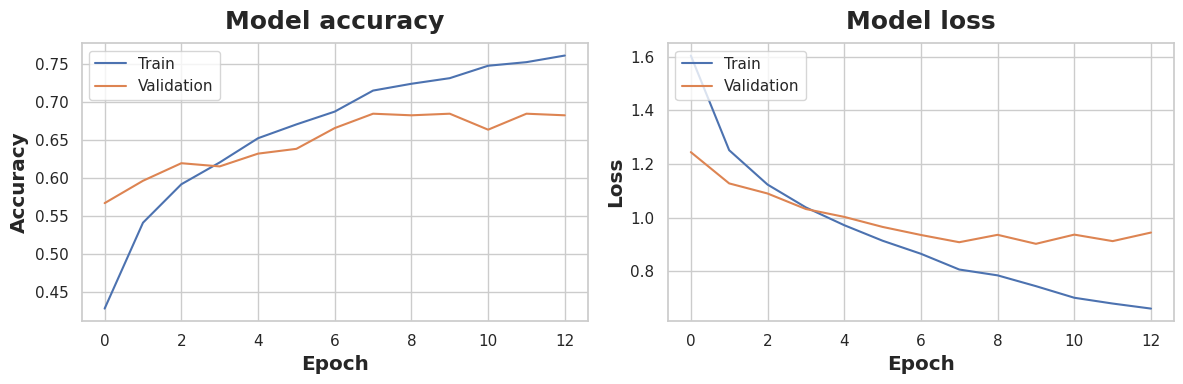

In [12]:
# ROUND ONE

# Train the classifier
history = classifier.fit(
    train_features, train_labels,
    validation_data=(valid_features, valid_labels),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

The accuracy measures how often the model's predictions are correct and the loss measures how well the model's predictions match the actual labels.  

As the epochs go by the model's training accuracy is improving, and the loss is decreasing, indicating that the model is learning and improving.

The validation accuracy and loss are also being tracked to ensure the model generalises well to unseen data.

Improvements could be made by changing the batch size. Larger batch sizes can provide more stable gradient estimates, which can lead to smoother and potentially faster convergence and help in better generalising the model.  

Now try a larger batch size, going from 32 to 64.

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7497 - loss: 0.6742 - val_accuracy: 0.6765 - val_loss: 0.8944
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7775 - loss: 0.6195 - val_accuracy: 0.6828 - val_loss: 0.9009
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7746 - loss: 0.5962 - val_accuracy: 0.6870 - val_loss: 0.8786
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7888 - loss: 0.5762 - val_accuracy: 0.6849 - val_loss: 0.8757
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8034 - loss: 0.5516 - val_accuracy: 0.6828 - val_loss: 0.8720
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8057 - loss: 0.5335 - val_accuracy: 0.6828 - val_loss: 0.8615
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8226 - loss: 0.5088 - val_accuracy: 0.7017 - val_loss: 0.8469
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.4883 - val_accuracy: 0.6786 - val_loss:

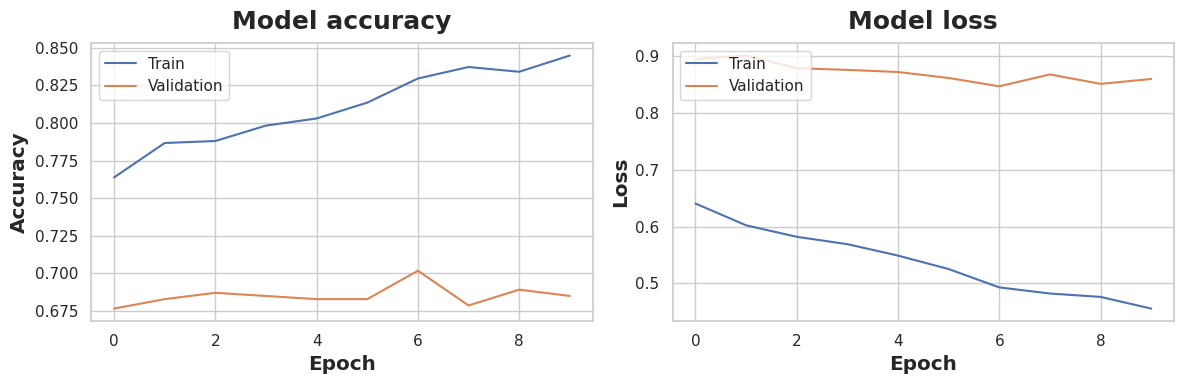

In [13]:
# Train the classifier
history = classifier.fit(
    train_features, train_labels,
    validation_data=(valid_features, valid_labels),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

The training accuracy has increased, from : 0.7514  up to 0.8462.  

The numbers may show improvement, but the wide gaps between training and validation accuracy show it is now overfitting!  

Augmenting the data more can combat overfitting.

the accuracy went down 84 to 78
eh
Overall, the new model shows a more consistent improvement in both training and validation metrics, with less fluctuation. However, the training accuracy and loss are slightly worse than the previous model. The validation metrics are comparable, indicating that the new model might be generalizing better.  

Add more data augmentation now


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3017 - loss: 1.9836 - val_accuracy: 0.5231 - val_loss: 1.3732
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4848 - loss: 1.4246 - val_accuracy: 0.5819 - val_loss: 1.2288
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5453 - loss: 1.2839 - val_accuracy: 0.5945 - val_loss: 1.1585
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5724 - loss: 1.1946 - val_accuracy: 0.6092 - val_loss: 1.1140
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5925 - loss: 1.1235 - val_accuracy: 0.6324 - val_loss: 1.0575
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6128 - loss: 1.0670 - val_accuracy: 0.6345 - val_loss: 1.0400
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6378 - loss: 1.0195 - val_accuracy: 0.6471 - val_loss: 0.9939
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6498 - loss: 0.9816 - val_accuracy: 0.6513 - val_loss:

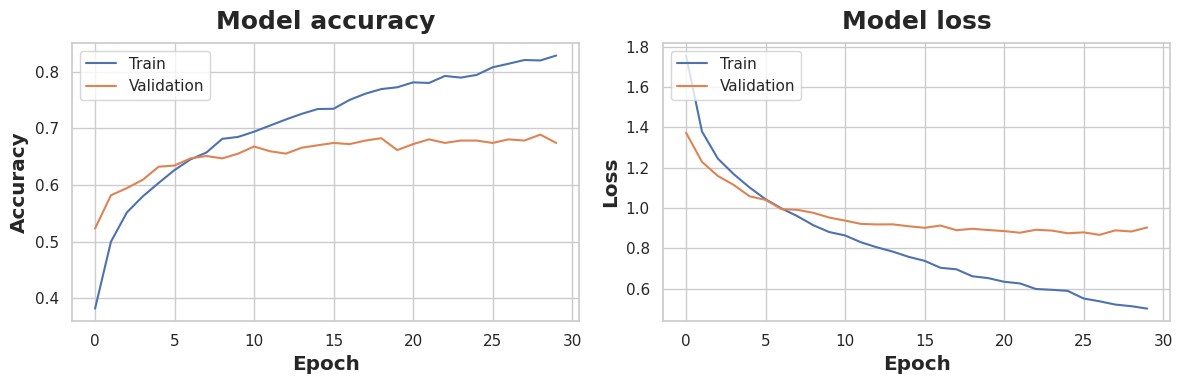

In [16]:
# Add to the data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

# Apply augmentation
augmented_train_dataset = train_dataset_normalized.map(lambda x, y: (data_augmentation(x, training=True), y))

# classifying head
classifier = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_classifier.keras', save_best_only=True)

# Train the classifier
history = classifier.fit(
    train_features, train_labels,
    validation_data=(valid_features, valid_labels),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

The training accuracy has decreased down to 0.8257 and validation accuracy slightly down, to 0.6744 from 0.6849. The augmentated data may not be providing enough diversity.

Another option is to try altering the drop out rate. The dropout rate specifies the fraction of input units to be randomly set to zero during training. This makes the model more robust and less reliant on specific neurons.

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2987 - loss: 2.0443 - val_accuracy: 0.5231 - val_loss: 1.4033
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4544 - loss: 1.4772 - val_accuracy: 0.5672 - val_loss: 1.2545
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5100 - loss: 1.3454 - val_accuracy: 0.5609 - val_loss: 1.1940
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5597 - loss: 1.2519 - val_accuracy: 0.6050 - val_loss: 1.1265
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5826 - loss: 1.1869 - val_accuracy: 0.6261 - val_loss: 1.0913
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5947 - loss: 1.1311 - val_accuracy: 0.6261 - val_loss: 1.0490
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6175 - loss: 1.0846 - val_accuracy: 0.6197 - val_loss: 1.0387
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6247 - loss: 1.0187 - val_accuracy: 0.6345 - val_loss:

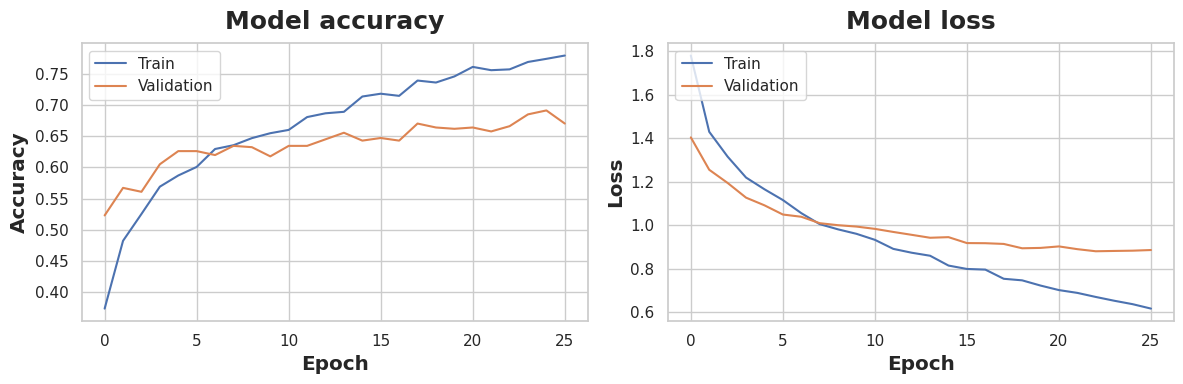

In [18]:
# alter the dropout rate
classifier = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3), # was 0.2 before
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_classifier.keras', save_best_only=True)

# Train the classifier
history = classifier.fit(
    train_features, train_labels,
    validation_data=(valid_features, valid_labels),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Increasing the dropout rate from 0.2 to 0.3 has led to a decrease in both training and validation accuracy, but it has also brought the training and validation loss curves closer together.  
The closer alignment of the training and validation loss curves suggests that the model is overfitting less.

In [19]:
# evaluate
test_loss, test_accuracy = classifier.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6847 - loss: 0.8586 
Test Loss: 0.8617305159568787
Test Accuracy: 0.6847599148750305


In [20]:
# save
classifier.save('final_classico.keras')

**RESULTS & DISCUSSION**  

Display the results via a confusion matrix.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                     precision    recall  f1-score   support

          Cardboard       0.79      0.72      0.76        47
      Food Organics       0.67      0.57      0.62        42
              Glass       0.97      0.74      0.84        42
              Metal       0.71      0.68      0.70        79
Miscellaneous Trash       0.51      0.44      0.47        50
              Paper       0.67      0.68      0.67        50
            Plastic       0.60      0.81      0.68        93
      Textile Trash       0.64      0.50      0.56        32
         Vegetation       0.81      0.86      0.84        44

           accuracy                           0.68       479
          macro avg       0.71      0.67      0.68       479
       weighted avg       0.69      0.68      0.68       479



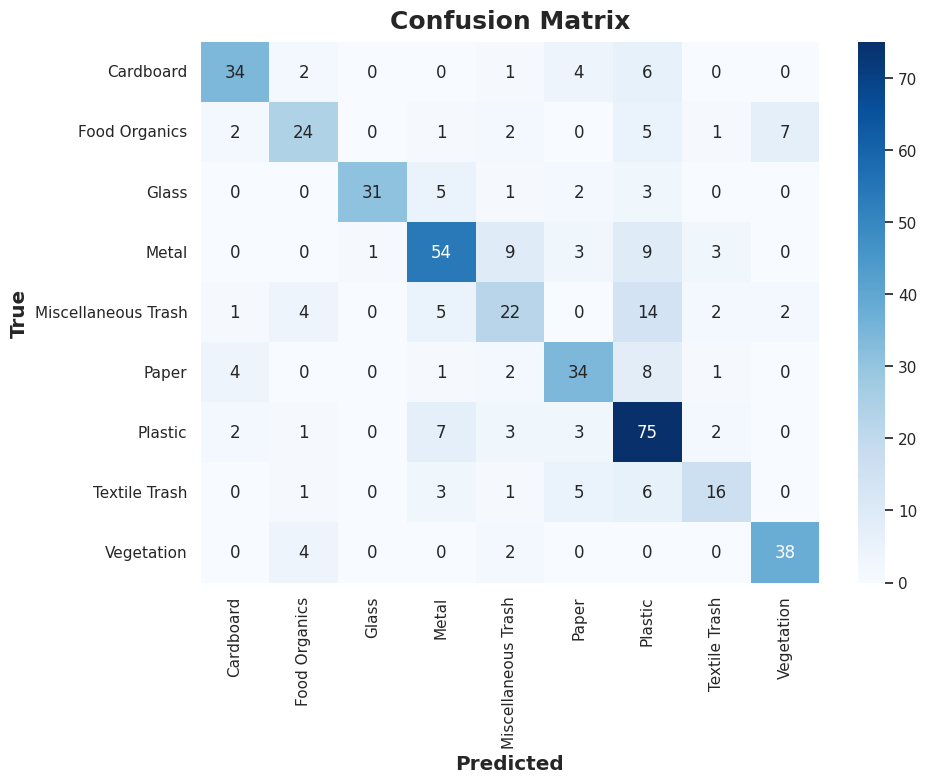

In [21]:
# confusion matrices are the best
predictions = classifier.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=categories))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The model's overall accuracy is 68%, which is just short of the baseline of 70% that was the desireable objective, but is a solid foundation.

The confusion matrix evaluates via precision, recall and an F1 score. Precision is measures the accuracy of positive predictions; recall measures the ability to identify all relevant instances, and the F1-Score is the harmonic mean of precision and recall.

Examing the results of the class performance is interesting. Glass has the highest precision (0.97) and a good f1-score (0.84), indicating the model is very good at identifying it correctly. Vegetation also performs well with high precision (0.81) and recall (0.86), resulting in a strong f1-score (0.84).
However, miscellaneous trash has the lowest performance with a precision of 0.51 and recall of 0.44, leading to an f1-score of 0.47. So the model is struggling to correctly identify it. Perhaps this is not so surprising - when something is classed as 'miscallaneous' by a human, it is because they are unsure of how to classify it, it's a 'thing' not easy to define and so the model is also unsure.

Cardboard (0.79) also has high precison numbers and Plastic (0.81) high recall numbers, which indicates fewer false negatives.  


*Pre-trained model choice*  
"Simpler models are less likely to overfit than complex ones" according to Chollet and overfitting is a common problem for small datasets, hence the lightweight MobileNetV2 was chosen.  

Overfitting occurs when a model learns the training data too well, capturing noise and specific patterns that do not generalize to new, unseen data. This results in high accuracy on the training set but poor performance on the validation or test sets. Small datasets exacerbate this issue because the model has fewer examples to learn from, increasing the likelihood of memorising the training data rather than learning generalisable features.

MobileNetV2 achieved an impressive 88.15% accuracy on the RealWaste dataset, demonstrating its capability to handle real-world waste classification effectively. They report it performed well in terms of precision, recall, and F1-scores, indicating a good balance between identifying true positives and minimizing false positives. It also did not have an excessively long training time when this author used it in Colab (unlike some of the more complex models that caused Colab to crash).  

*Tuning the model*  
Studies have demonstrated that data augmentation can lead to substantial improvements in model performance. These transformations create diverse variations of the original images, helping the model generalize better to new data and this was attempted.  

Dropout is a regularisation technique used to prevent overfitting in neural networks, which was also used. It prevents the model from becoming too reliant on specific neurons and encourages it to learn more robust features. Research has shown that dropout can significantly improve the generalisation of CNNs, making them less prone to overfitting and it did appear to help convergence in the model.


** CONCLUSIONS**  
Single et al found that nearly all the models experimented with had difficulty distinguishing between similar materials like plastic and glass, and between cardboard, metal, and paper. This highlights the complexity of the waste feature space - especially when material is not pristine - and the need for further refinement in dataset labelling and model training.

**REFERENCES**
1. Single, S., Iranmanesh, S., & Raad, R. (2023). RealWaste: A Novel Real-Life Data Set for Landfill Waste Classification Using Deep Learning. Information, 14(12), 633. https://doi.org/10.3390/info14120633
2. Umesh Kumar Lilhore, Sarita Simaiya, Surjeet Dalal, Magdalena Radulescu, Daniel Balsalobre-Lorente, Intelligent waste sorting for sustainable environment: A hybrid deep learning and transfer learning model,
Gondwana Research, 2024,ISSN 1342-937X, https://doi.org/10.1016/j.gr.2024.07.014
3. Chollet, F. (2017). Deep learning with python. Manning Publications.
4. Melinte, D.O.; Travediu, A.-M.; Dumitriu, D.N. Deep Convolutional Neural Networks Object Detector for Real-Time Waste Identification. Appl. Sci. 2020, 10, 7301 https://doi.org/10.3390/app10207301
5. Zhang, Q.; Zhang, X.; Mu, X.; Wang, Z.; Tian, R.; Wang, X.; Liu, X. Recyclable waste image recognition based on deep learning. Resour. Conserv. Recycl. 2021, 171, 105636

Dataset: https://archive.ics.uci.edu/dataset/908/realwaste



